In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from utils.metrics import evaluate
import statsmodels.api as sm 

from sklearn import metrics
from sklearn import linear_model


from tqdm import tqdm

2023-12-18 10:48:43.451950: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 10:48:43.646882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 10:48:43.646961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 10:48:43.681895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 10:48:43.756905: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 10:48:43.758078: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
daily_data = pd.read_csv("/media/binhnguyenduc/ubuntu_sofware/vscode/Time_Series_Forecasting/HCM-forecast/data_precipitation_HCMC.csv")
daily_data.set_index('Timestamp', inplace=True)

what we want to predict

In [4]:
daily_data["Precipitation_yesterday"]=daily_data.shift(-1)["Precipitation"]


In [5]:
daily_data

,Temperature,Sunshine_Duration,Precipitation,CAPE,MSLP,Wind_Speed,Precipitation_yesterday
Timestamp,,,,,,,
2017-01-01,-2.005171,495.983845,0.0,0.000000,1024.850000,5.347793,1.6
2017-01-02,-0.648505,135.298321,1.6,0.666667,1024.937500,4.559078,0.0
2017-01-03,-1.862255,144.031148,0.0,1.750000,1029.254167,3.285845,3.9
2017-01-04,0.025662,16.553367,3.9,18.708333,1023.445833,12.328243,1.1
2017-01-05,-0.131005,236.872048,1.1,10.333333,1029.266667,7.850705,0.0
...,...,...,...,...,...,...,...
2023-11-21,8.481495,261.476939,5.4,15.500000,1015.837500,7.802274,0.4
2023-11-22,4.570662,18.354884,0.4,6.958333,1026.962500,9.803991,0.0
2023-11-23,4.004829,414.778780,0.0,0.000000,1028.425000,5.085261,3.3


last row is NAN

In [6]:
daily_data = daily_data.iloc[:-1,:].copy()

In [7]:
daily_data

,Temperature,Sunshine_Duration,Precipitation,CAPE,MSLP,Wind_Speed,Precipitation_yesterday
Timestamp,,,,,,,
2017-01-01,-2.005171,495.983845,0.0,0.000000,1024.850000,5.347793,1.6
2017-01-02,-0.648505,135.298321,1.6,0.666667,1024.937500,4.559078,0.0
2017-01-03,-1.862255,144.031148,0.0,1.750000,1029.254167,3.285845,3.9
2017-01-04,0.025662,16.553367,3.9,18.708333,1023.445833,12.328243,1.1
2017-01-05,-0.131005,236.872048,1.1,10.333333,1029.266667,7.850705,0.0
...,...,...,...,...,...,...,...
2023-11-20,11.129412,154.781823,0.4,11.625000,1016.316667,14.029652,5.4
2023-11-21,8.481495,261.476939,5.4,15.500000,1015.837500,7.802274,0.4
2023-11-22,4.570662,18.354884,0.4,6.958333,1026.962500,9.803991,0.0


Prepare data

In [8]:
resultsDict = {}
predictionsDict = {}
split_date = '2023-01-01'
df_training = daily_data.loc[daily_data.index <= split_date]
df_test = daily_data.loc[daily_data.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('training.csv')
df_test.to_csv('test.csv')

2192 days of training data 
 327 days of testing data 


In [9]:
# Also add the naive mean average value
mean = df_training.Precipitation.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Precipitation, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test.Precipitation, df_test.Precipitation_yesterday)
predictionsDict['Yesterdays value'] = df_test.Precipitation_yesterday.values

ARIMA

In [10]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Precipitation))):
    temp_train = daily_data[:len(df_training)+t]
    model = sm.tsa.arima.ARIMA(temp_train.Precipitation, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Precipitation, yhat.values)
predictionsDict['ARIMA'] = yhat.values

  0%|          | 0/327 [00:00<?, ?it/s]

/media/binhnguyenduc/ubuntu_sofware/anaconda3/envs/newpython/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/media/binhnguyenduc/ubuntu_sofware/anaconda3/envs/newpython/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/media/binhnguyenduc/ubuntu_sofware/anaconda3/envs/newpython/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
  0%|          | 1/327 [00:00<00:41,  7.83it/s]/media/binhnguyenduc/ubuntu_sofware/anaconda3/envs/newpython/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

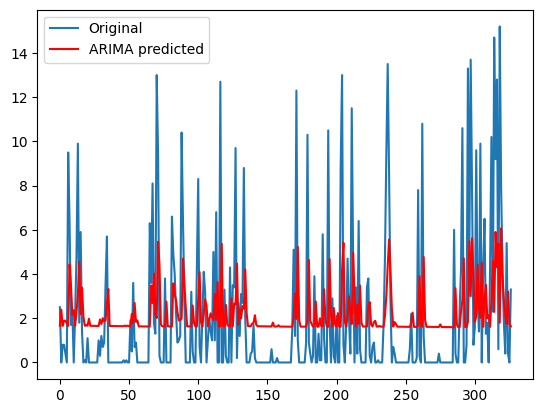

In [11]:
plt.plot(df_test.Precipitation.values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

Multivariable 

In [12]:
# ADD time features to our model
def create_time_features(df, target=None):
    

    df['date'] = df.index
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
!pip install xgboost

In [13]:
X_train_df, y_train = create_time_features(
    df_training, target='Precipitation')
X_test_df, y_test = create_time_features(df_test, target='Precipitation')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

/tmp/ipykernel_11026/3402543081.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_11026/3402543081.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
/tmp/ipykernel_11026/3402543081.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Xgboost

In [17]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.Precipitation, yhat)
predictionsDict['XGBoost'] = yhat

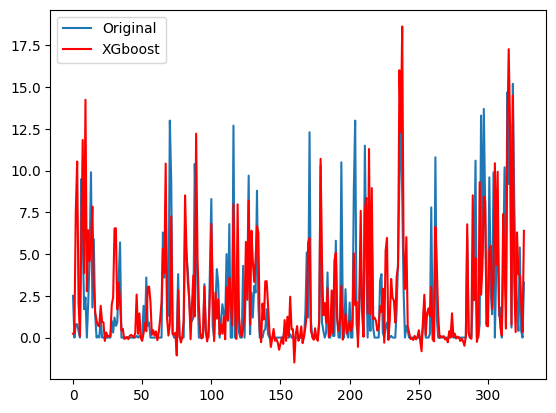

In [18]:
plt.plot(df_test.Precipitation.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [19]:
print("MAE" , metrics.mean_absolute_error(df_test.Precipitation, yhat))
print("MSE" , metrics.mean_squared_error(df_test.Precipitation, yhat))
print("RMSE" , np.sqrt(metrics.mean_squared_error(df_test.Precipitation, yhat)))
print("R2" , metrics.explained_variance_score(df_test.Precipitation, yhat))

MAE 1.6525344899434036
MSE 7.699922080606953
RMSE 2.774873344966749
R2 0.33087468104702933


Deeplearning LSTM

In [20]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


2023-12-18 10:59:11.117682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 10:59:11.118552: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [22]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/5
200/200 [==============================] - 4s 15ms/step - loss: 1.5867 - val_loss: 0.8515
Epoch 2/5
200/200 [==============================] - 3s 13ms/step - loss: 0.5203 - val_loss: 0.3738
Epoch 3/5
200/200 [==============================] - 3s 13ms/step - loss: 0.3227 - val_loss: 0.2356
Epoch 4/5
200/200 [==============================] - 3s 13ms/step - loss: 0.2588 - val_loss: 0.3250
Epoch 5/5
200/200 [==============================] - 3s 13ms/step - loss: 0.2355 - val_loss: 0.1654


In [23]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

11/11 [==============================] - 0s 5ms/step


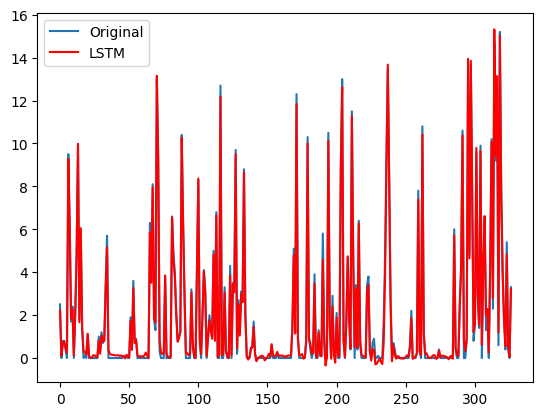

In [24]:
plt.plot(df_test.Precipitation.values, label='Original')
plt.plot(yhat, color='red', label='LSTM')
plt.legend()

In [25]:
print("MAE" , metrics.mean_absolute_error(df_test.Precipitation, yhat))
print("MSE" , metrics.mean_squared_error(df_test.Precipitation, yhat))
print("RMSE" , np.sqrt(metrics.mean_squared_error(df_test.Precipitation, yhat)))
print("R2" , metrics.explained_variance_score(df_test.Precipitation, yhat))

MAE 0.16628266508243864
MSE 0.053993053149589236
RMSE 0.23236405304949653
R2 0.9952287316585272
